<a href="https://colab.research.google.com/github/ncsu-geoforall-lab/geomorphometry2025_workshop/blob/main/geomorphometry_2025_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workshop: Propagating DEM Uncertainty to Stream Extraction using GRASS

<a name="start"></a>
### Start GRASS and Create a New Project

First, we'll install GRASS:

In [1]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.4 LTS
Release:	22.04
Codename:	jammy


In [ ]:
# !pip install rpy2==3.1.0 pandas

In [2]:
!add-apt-repository -y ppa:ubuntugis/ubuntugis-unstable
!apt update
!apt-get install -y grass-core grass-dev

PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/ubuntugis/ubuntugis-unstable/ubuntu/ jammy main'
Description:
Unstable releases of Ubuntu GIS packages. These releases are more bleeding edge and while generally they should work well, they dont receive the same amount of quality assurance as our stable releases do.
More info: https://launchpad.net/~ubuntugis/+archive/ubuntu/ubuntugis-unstable
Adding repository.
Adding deb entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ubuntugis-unstable-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ubuntugis-unstable-jammy.list
Adding key to /etc/apt/trusted.gpg.d/ubuntugis-ubuntu-ubuntugis-unstable.gpg with fingerprint 2EC86B48E6A9F326623CD22FFF0E7BBEC491C6A1
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:3 http

In [4]:
!grass --version

GRASS GIS 8.4.1
Geographic Resources Analysis Support System (GRASS) is Copyright,
1999-2025 by the GRASS Development Team, and licensed under terms of the
GNU General Public License (GPL) version >=2.

This GRASS GIS 8.4.1 release is coordinated and produced by
the GRASS Development Team with contributions from all over the world.

This program is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU
General Public License for more details.
GRASS GIS 8.4.1
Geographic Resources Analysis Support System (GRASS) is Copyright,
1999-2025 by the GRASS Development Team, and licensed under terms of the
GNU General Public License (GPL) version >=2.

This GRASS GIS 8.4.1 release is coordinated and produced by
the GRASS Development Team with contributions from all over the world.

This program is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; withou

Now, we can import GRASS's Python APIs, `grass.scripts` and `grass.jupyter` into our Python environment.

In [5]:
import sys
import subprocess
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ask GRASS where its Python packages are to be able to run it from the notebook
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)
import grass.script as gs
import grass.jupyter as gj

With our packages imported, we can now create a new project called "geomorphometry_workshop". Projects are defined by a Coordinate Reference System (CRS). We can set the CRS from a georeferenced file (such as a Geotiff) or an EPSG string. Here, we use [EPSG 3358](https://epsg.io/32632), a projection for NC in meters.

In [6]:
gs.create_project("geomorphometry_workshop", epsg="32632")

We start a GRASS session in our new project.

In [7]:
gj.init("geomorphometry_workshop");

Draw Computational Region

In [10]:
!pip install ipyleaflet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.7 MB/s eta 0:00:00


In [14]:
from IPython.display import display, Image

m = gj.InteractiveMap(map_backend="ipyleaflet")
m.add_layer_control()
display(m.show())

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

Alternatively, set region with g.region to the approximate bounds of a watershed near Perugia that opens into a flat plain. Also, set the resolution to 10m (same as TINItaly).

In [15]:
print(gs.read_command("g.region", n=4779200, s=4776000, e=783000, w=777600, res=10, flags="pa"))

projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      4779200
south:      4776000
west:       777600
east:       783000
nsres:      10
ewres:      10
rows:       320
cols:       540
cells:      172800



In [17]:
from IPython.display import display, Image

m = gj.InteractiveMap(use_region=True, map_backend="ipyleaflet")
m.add_layer_control()
display(m.show())

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

Import Data (this isn't working so well for me..). It ends in an error but somehow still imports the data. It creates elevation.1 and elevation.2 instead of one elevation layer.

In [18]:
from grass.exceptions import CalledModuleError

try:
  gs.run_command("r.in.wms",
    url="http://tinitaly.pi.ingv.it/TINItaly_1_1/wms?service=WMS",
    output="elevation",
    format="geotiff",
    method="cubicspline",
    wms_version="1.3.0",
    layers="TINItaly_1.1:tinitaly_dem",
    srs="32632",
    flags="",
    overwrite=True,
    quiet=True
  )
except CalledModuleError as e:
  print(e)

Module run `r.in.wms --o --q url=http://tinitaly.pi.ingv.it/TINItaly_1_1/wms?service=WMS output=elevation format=geotiff method=cubicspline wms_version=1.3.0 layers=TINItaly_1.1:tinitaly_dem srs=32632` ended with an error.
The subprocess ended with a non-zero return code: 1. See errors above the traceback or in the error output.


ERROR: Raster map <elevation> not found
Traceback (most recent call last):
  File "/usr/lib/grass84/scripts/r.in.wms", line 289, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/lib/grass84/scripts/r.in.wms", line 282, in main
    importer.ImportMapIntoGRASS(fetched_map)
  File "/usr/lib/grass84/etc/r.in.wms/wms_base.py", line 619, in ImportMapIntoGRASS
    os.environ["GRASS_REGION"] = grass.region_env(rast=region_map)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/grass84/etc/python/grass/script/core.py", line 1322, in region_env
    s = read_command("g.region", flags=flgs, env=env, **kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/grass84/etc/python/grass/script/core.py", line 554, in read_command
    return handle_errors(returncode, stdout, args, kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/grass84/etc/python/grass/script/core.py", line 366, in handle

In [19]:
print(gs.read_command("g.region", raster="elevation.1", flags="pa"))

projection: 1 (UTM)
zone:       32
datum:      wgs84
ellipsoid:  wgs84
north:      4779200
south:      4776000
west:       777600
east:       783000
nsres:      10
ewres:      10
rows:       320
cols:       540
cells:      172800



In [20]:
!g.list type=all

elevation
elevation.1
elevation.2


TODO: display this data and look at a history

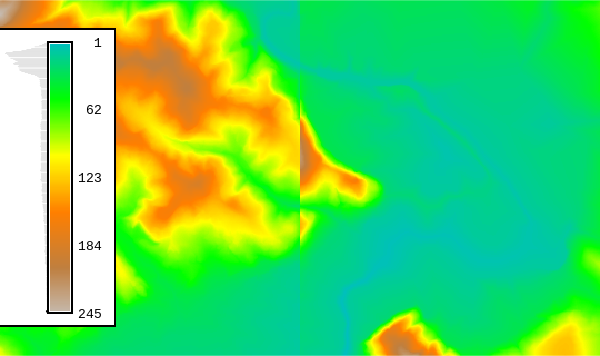

In [21]:
gs.run_command("r.colors", map="elevation.1,elevation.2", color="elevation")

m = gj.Map(use_region=True)
m.d_rast(map="elevation.1")
m.d_legend(raster="elevation.1", flags="bds")
m.show()

Sample Points

TODO: Statified sampling by landcover to mimic Lidar? Like lower frequency in heavily vegetated areas and none in water/buildings?

In [22]:
gs.run_command("r.random", input="elevation.1", vector="elevrand", n=1000, flags="s")

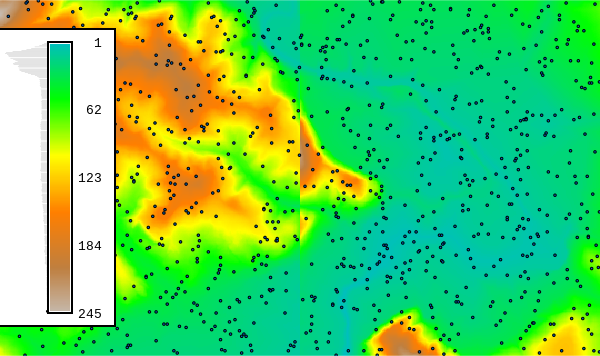

In [23]:
m = gj.Map(use_region=True)
m.d_rast(map="elevation.1")
m.d_vect(map="elevrand", color="black", icon="basic/point")
m.d_legend(raster="elevation.1", flags="bds")
m.show()

In [24]:
gs.run_command("r.slope.aspect", elevation="elevation.1", slope="slope", aspect="aspect", overwrite=True)

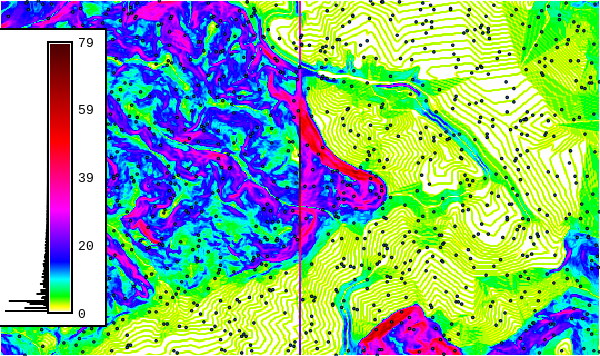

In [25]:
gs.run_command("r.colors", map="slope", color="slope")

m = gj.Map(use_region=True)
m.d_rast(map="slope")
m.d_vect(map="elevrand", color="black", icon="basic/point")
m.d_legend(raster="slope", flags="bds")
m.show()

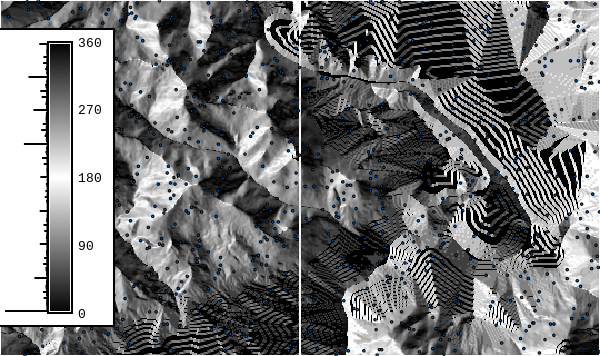

In [26]:
m = gj.Map(use_region=True)
m.d_rast(map="aspect")
m.d_vect(map="elevrand", color="black", icon="basic/point")
m.d_legend(raster="aspect", flags="bds")
m.show()

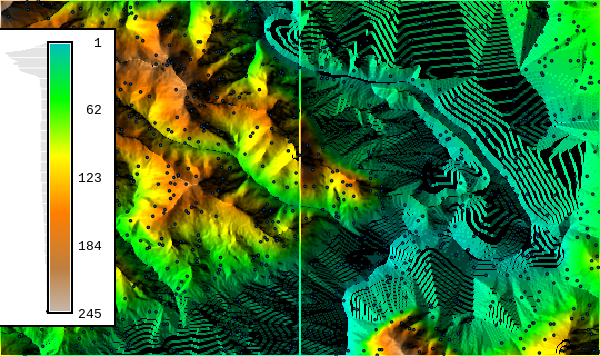

In [27]:
m = gj.Map(use_region=True)
m.d_shade(shade="aspect", color="elevation.1", brighten=30)
m.d_vect(map="elevrand", color="black", icon="basic/point")
m.d_legend(raster="elevation.1", flags="bds")
m.show()

In [41]:
from ipyleaflet import ImageService, WMSLayer

m = gj.InteractiveMap(use_region=True, map_backend="ipyleaflet", width=800, height=600)


im = ImageService(
    url='https://landsat.arcgis.com/arcgis/rest/services/Landsat/PS/ImageServer',
    rendering_rule={"rasterFunction":"Pansharpened Enhanced with DRA"},
    format='jpgpng',
    attribution='United States Geological Survey (USGS), National Aeronautics and Space Administration (NASA)'
)

wms = WMSLayer(
    url='http://tinitaly.pi.ingv.it/TINItaly_1_1/wms?service=WMS',
    layers='TINItaly_1.1:tinitaly_hshd',
    format='image/png',
    transparent=True,
    attribution='Elevation Data © 2023 TINItaly 1.1'
)


m.map.add(im)
m.map.add(wms)
m.add_raster("elevation.1", opacity=0.5)
m.add_vector("elevrand")
m.add_layer_control()
display(m.show())

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

## Move to R for Kriging

Set up R.

Load rpy2 extension. rpy2 is an interface to R running embedded in a Python process allowing up to continue operating in our current Python session but cells in R.

In [42]:
%load_ext rpy2.ipython

Now, we can use the %%R cell magic. When this cell is interpreted, it's contents will be sent to R. We could also use line magic now with %R which would only send the line to R.

In [43]:
%%R
system("apt-get install r-cran-sf")

In [44]:
%%R
system("apt-get install r-cran-gstat r-cran-terra r-cran-devtools r-cran-irkernel")

We also need the rgrass package which is distributed on GitHub.

In [45]:
%%R
devtools::install_git("https://github.com/rsbivand/rgrass")

── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpKSf0JS/filea552bfa939/DESCRIPTION’ ... OK
* preparing ‘rgrass’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘rgrass_0.5-1.tar.gz’



'/usr/bin/git' clone --depth 1 --no-hardlinks https://github.com/rsbivand/rgrass /tmp/RtmpKSf0JS/filea552bfa939
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Load libraries.
- Tell R to use the system packages

In [46]:
%%R

library(gstat)
library(rgrass)
library(terra)
library(sf)

GRASS GIS interface loaded with GRASS version: GRASS 8.4.1 (2025)
and location: geomorphometry_workshop
terra 1.8.42
Compiled with:3.10.2-CAPI-1.16.0
 Running with:3.11.1-CAPI-1.17.1

You should reinstall package 'terra'

Linking to GEOS 3.11.1, GDAL 3.4.3, PROJ 8.2.1; sf_use_s2() is TRUE
Linked against: 3.11.1-CAPI-1.17.1 compiled against: 3.10.2-CAPI-1.16.0
It is probably a good idea to reinstall sf (and maybe lwgeom too)


Use readVECT from rgrass to turn the random elevation points into a [SpatVector](https://rdrr.io/cran/terra/man/SpatVector-class.html), the terra vector class.

In [47]:
%%R
elevrand <- read_VECT("elevrand")

Exporting 1000 features...
   5%  11%  17%  23%  29%  35%  41%  47%  53%  59%  65%  71%  77%  83%  89%  95% 100%
v.out.ogr complete. 1000 features (Point type) written to <elevrand> (GPKG
format).


In [48]:
%%R
# Convert to sf-style data frame for gstat
elev_df <- as.data.frame(elevrand, geom = "XY")

In [49]:
%%R
# Create gstat object
g <- gstat(formula = value ~ 1, data = elev_df, locations = ~x + y)

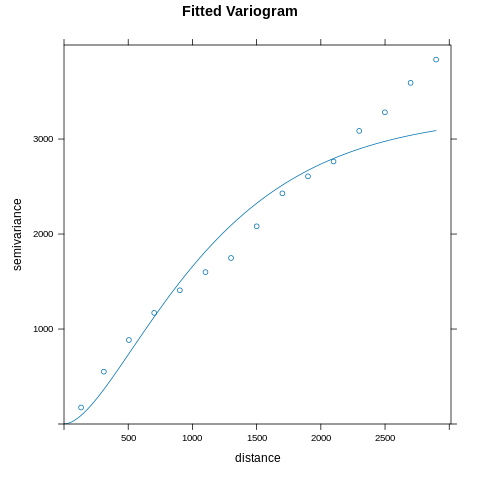

In [50]:
%%R
# Compute experimental variogram
vg <- variogram(g, cutoff = 3000)

# Fit a model (Exponential by default; can also try Matérn via 'fit.variogram')
vfit <- fit.variogram(vg, model = vgm(model = "Mat", kappa = 1.2), fit.kappa = FALSE)

# Plot variogram and fitted model
plot(vg, model = vfit, main = "Fitted Variogram")

In [51]:
%%R

ext <- ext(elevrand)
res <- 10  # 10-meter spacing

xy <- expand.grid(
  x = seq(ext[1], ext[2], by = res),
  y = seq(ext[3], ext[4], by = res)
)

# demgrid_sf <- st_as_sf(demgrid, crs = crs(elevrand),  as_points = TRUE)
g <- gstat(formula = value ~ 1, model = vfit, data = elev_df, locations=~x+y)

In [52]:
%%R

z <- predict(g, xy)

[using ordinary kriging]


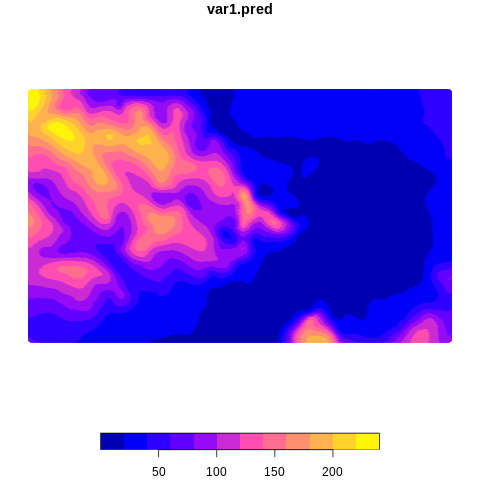

In [53]:
%%R

z_sf <- st_as_sf(z, coords = c("x", "y"), crs = crs(elevrand))

plot(z_sf["var1.pred"])

Run the stochastic simulation n times

In [ ]:
%%R
N.sim <- 10
z_sim <- predict(g, newdata=xy, nsim = N.sim )

drawing 10 GLS realisations of beta...
[using conditional Gaussian simulation]


Calculate the mean and standard deviation of the simulatate surfaces

In [ ]:
for(i in 1:N.sim) {writeRAST(z_sim[i], paste("simulated_", i, sep=""))}
execGRASS("g.list", type="raster", pattern="simulated_*", output="tmp_list_simulated.txt")
execGRASS("r.series", file="tmp_list_simulated.txt", output="simulated_mean", method="average")
execGRASS("r.series", file="tmp_list_simulated.txt", output="simulated_std", method="stddev")

Generate streams for each DEM

In [ ]:
for(i in 1:N.sim) {execGRASS("r.watershed", elevation=paste("simulated_", i, sep=""),
 threshold=30, stream=paste("stream_", i, sep=""), flags=c("quiet"))}

Calculate the probablity and error

In [ ]:
execGRASS("g.list", type="raster", pattern="stream*", output="tmp_list_stream.txt")
execGRASS("r.series", file="tmp_list_stream.txt", output="count", method="count")
execGRASS("r.mapcalc", expression=paste("prob = float(count)/", N.sim))
execGRASS("r.mapcalc", expression="error = -prob * log(prob) - (1-prob)* log(1-prob)")

In [ ]:
%%bash

r.colors simulated_mean rast=elevation_10
r.colors simulated_10 rast=elevation_10
r.colors simulated_std co=bcyr -e
r.colors aspect_10 co=aspect
r.slope.aspect simulated_mean slo=slp_mean asp=asp_mean
r.slope.aspect simulated_10 slo=slp_10 asp=asp_10
r.mapcalc "diff_spline_gsim = elevation_10 - simulated_mean"
r.colors diff_spline_gsim co=differences

Original Workflow:

https://github.com/ncsu-geoforall-lab/GIS714-assignments/blob/main/Surface_Water_Simulations/WaterSim-Geostatistical-Simulations.ipynb

TUTORIAL Option:

https://geobgu.xyz/r/spatial-interpolation-of-point-data.html